In [1]:
import pandas as pd

In [2]:
# read JSON and slice first 4 cols
df = pd.read_json("airyards.json").iloc[:,[i for i in range(4)]]
df.head(3)

,name,position,team,total
0,Christian McCaffrey,RB,CAR,"{'targets': 142, 'rec': 116, 'rec_yards': 1005..."
1,Michael Thomas,WR,NO,"{'targets': 185, 'rec': 149, 'rec_yards': 1725..."
2,Aaron Jones,RB,GB,"{'targets': 68, 'rec': 49, 'rec_yards': 474, '..."


In [3]:
# flatten
totals = pd.io.json.json_normalize(df['total'])
totals.head(3)

,adot,air_yards,ms_air,ppr,racr,rec,rec_yards,targets,td,tgt_share,wopr,yac
0,0.7,95,0.02,469.2,10.58,116,1005,142,4,0.22,0.35,1019
1,8.0,1488,0.40,374.6,1.16,149,1725,185,9,0.32,0.75,583
2,2.8,190,0.04,318.8,2.49,49,474,68,3,0.12,0.20,433


In [4]:
# replace compressed totals with expanded
df.drop(columns='total', inplace=True)
df = pd.concat([df, totals], axis=1, join='inner')
df.head(3)

,name,position,team,adot,air_yards,ms_air,ppr,racr,rec,rec_yards,targets,td,tgt_share,wopr,yac
0,Christian McCaffrey,RB,CAR,0.7,95,0.02,469.2,10.58,116,1005,142,4,0.22,0.35,1019
1,Michael Thomas,WR,NO,8.0,1488,0.40,374.6,1.16,149,1725,185,9,0.32,0.75,583
2,Aaron Jones,RB,GB,2.8,190,0.04,318.8,2.49,49,474,68,3,0.12,0.20,433


JSON now parsed back to website format
test below: 

In [5]:
df.shape[0]

683

more players than shown online.

## Sorting & Separating Data

In [6]:
df.sort_values('position', inplace=True)
df.head(5)

,name,position,team,adot,air_yards,ms_air,ppr,racr,rec,rec_yards,targets,td,tgt_share,wopr,yac
682,Blake Bortles,QB,LA,0.0,-3,-0.01,-0.9,0.0,0,0,0,0,0.0,0.00,0
681,Tim Boyle,QB,GB,0.0,10,0.01,-0.7,0.0,0,0,0,0,0.0,0.01,0
343,Sam Darnold,QB,NYJ,0.0,3614,0.99,18.2,0.0,0,0,0,0,0.0,0.70,0
356,Jared Goff,QB,LA,0.0,4819,0.99,16.0,0.0,0,0,0,0,0.0,0.69,0
372,Marcus Mariota,QB,TEN,0.0,1134,0.73,12.9,0.0,0,0,0,0,0.0,0.51,0


In [7]:
# three groups of players
wrdf = df[df['position'] == 'WR']
tedf = df[df['position'] == 'TE']
rbdf = df[df['position'] == 'RB']
alldf = pd.concat([wrdf, tedf, rbdf], ignore_index=True)

In [8]:
import seaborn as sns

In [9]:
def stat_kde(stat: str):
    sns.kdeplot(
        data=alldf, x=stat, multiple="layer",
        hue="position", fill=True, palette="mako", 
        alpha=.4, linewidth=2,
        common_norm=False
    )

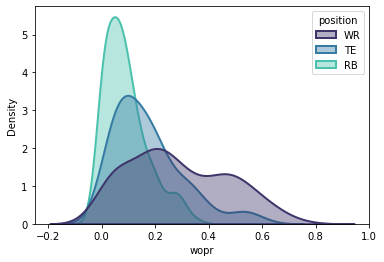

In [10]:
stat_kde('wopr')

Probability density plots of WOPR.

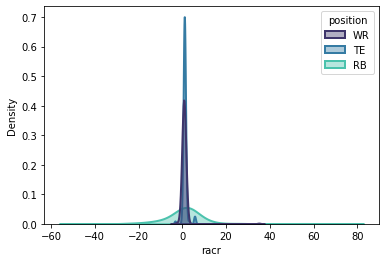

In [11]:
stat_kde('racr')

Density plots of RACR.

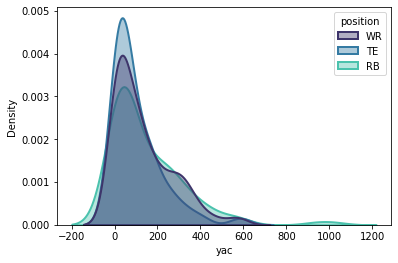

In [12]:
stat_kde('yac')

Density plots of YAC.

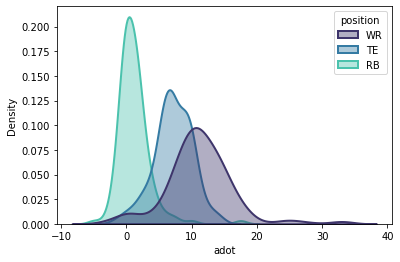

In [13]:
stat_kde('adot')

Density plots of Average Depth of Target.

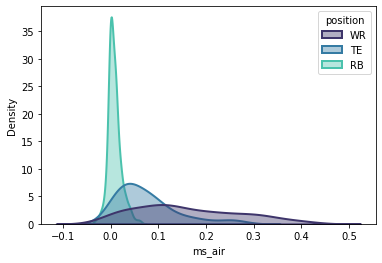

In [14]:
stat_kde('ms_air')

Density plots of Air Yards Market Share.

## WOPR as a predictor of VORP

VORP depends on league settings – in this case, a 10 team PPR league.

In [15]:
# scrape VORP data
vorp_df = pd.read_html("https://www.fantasypros.com/nfl/rankings/ppr-vorp.php?team_size=10")[0]
vorp_df.head(5)

,Rank,Player,POS,VORP,ADP,vs ADP
0,1,Christian McCaffrey (CAR),RB1,265,1.0,-
1,2,Dalvin Cook (MIN),RB2,208,2.0,-
2,3,Alvin Kamara (NO),RB3,192,3.0,-
3,4,Davante Adams (GB),WR1,188,7.0,+ 3
4,5,Travis Kelce (KC),TE1,174,8.0,+ 3


In [16]:
# remove Kickers, QBs, and defenses
vorp_df = vorp_df.loc[
    (vorp_df['POS'].str.contains('QB') == False) &
    (vorp_df['POS'].str.contains('K') == False) &
    (vorp_df['POS'].str.contains('DST') == False)
]